In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
sns.set_theme(style="darkgrid")


# Loading dataset

In [9]:
customers_df = pd.read_csv('Customers.csv')
customers_df.head()

,Age,Salary,Purchased
0,27,57000,0
1,19,76000,0
2,27,58000,0
3,27,84000,0
4,32,150000,1


# Basic exploration, data cleaning and augmentation
## Lets look at the ranges of values for each variable we are working with

In [10]:
customers_df.describe()

,Age,Salary,Purchased
count,380.000000,380.000000,380.000000
mean,37.807895,70739.473684,0.365789
std,10.571403,34059.516739,0.482286
min,18.000000,15000.000000,0.000000
25%,30.000000,44000.000000,0.000000
50%,37.000000,71000.000000,0.000000
75%,46.000000,88000.000000,1.000000
max,60.000000,150000.000000,1.000000


In [11]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Age        380 non-null    int64
 1   Salary     380 non-null    int64
 2   Purchased  380 non-null    int64
dtypes: int64(3)
memory usage: 9.0 KB


## Lets see if there are any obvious clusters

<AxesSubplot: xlabel='Age', ylabel='Salary'>

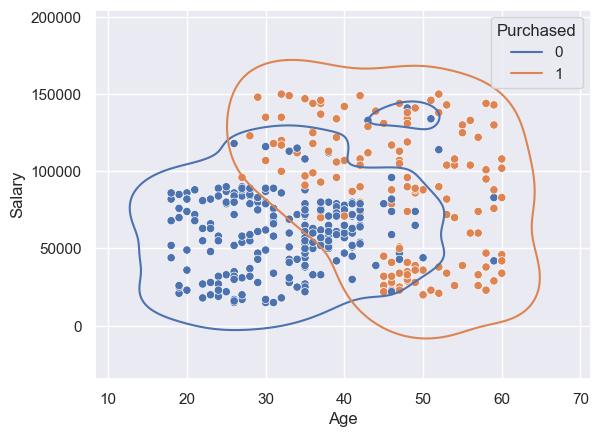

In [12]:
sns.scatterplot(data=customers_df, x="Age", y="Salary", hue="Purchased")
sns.kdeplot(data=customers_df, x="Age", y="Salary", hue="Purchased", levels=2)

## Lets see if there are any obvious biases in the dataset

<AxesSubplot: xlabel='Purchased', ylabel='Count'>

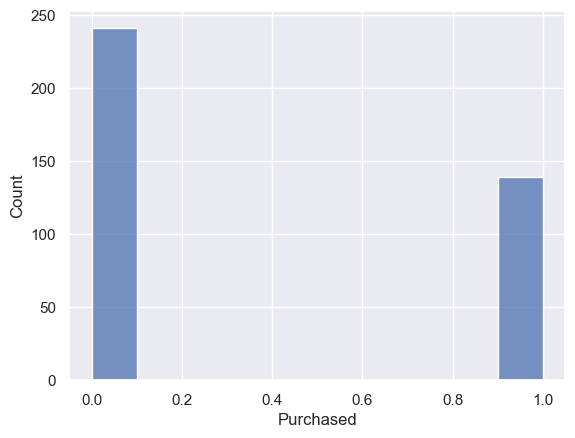

/Users/mkojro/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:254: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
/Users/mkojro/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:254: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<AxesSubplot: xlabel='Purchased', ylabel='Count'>

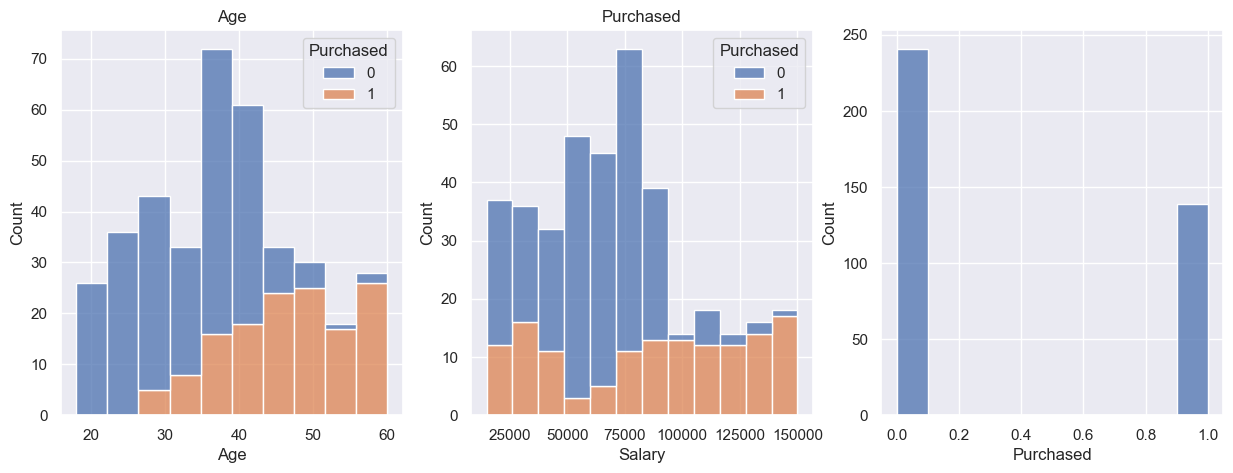

In [31]:
fig = plt.figure(figsize=(15, 5))
left_ax, center, right_ax = fig.add_subplot(1, 3, 1), fig.add_subplot(1, 3, 2), fig.add_subplot(1, 3, 3)
left_ax.set_title('Age')
sns.histplot(data=customers_df, x="Age", hue="Purchased", multiple="stack", ax=left_ax)
center.set_title('Salary')
sns.histplot(data=customers_df, x="Salary", hue="Purchased", multiple="stack", ax=center)
center.set_title('Purchased')
sns.histplot(data=customers_df, x="Purchased", ax=right_ax)

Looks like there is much more young people and people earning less money. Lets try to equalize the ratio a bit by using multiple copies of the same value in less populated ranges

In [15]:
customers_df["salary_range"] = pd.cut(customers_df["Salary"], bins=15, labels=False)
customers_df["age_range"] = pd.cut(customers_df["Age"], bins=15, labels=False)
sample = customers_df.groupby(["salary_range", "age_range"]).sample(100, replace=True)

In [8]:
fig = plt.figure(figsize=(10, 5))
left_ax, right_ax = fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)
left_ax.set_title('salary_range')
sns.histplot(data=sample, x="salary_range", hue="Purchased", multiple="stack", ax=left_ax)
right_ax.set_title('age_range')
sns.histplot(data=sample, x="age_range", hue="Purchased", multiple="stack", ax=right_ax)

# Model training
## Lets create the test and training datasets

In [28]:
data = sample[['salary_range', 'age_range']].to_numpy()
target = sample['Purchased'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(
    data, target, test_size=0.25, random_state=0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((11775, 2), (3925, 2), (11775,), (3925,))

## Lets use a logistic regression model (standard for binary classification)

In [17]:
model = LogisticRegression(max_iter=500000)

## Training the model

In [18]:
model.fit(x_train, y_train)

LogisticRegression(max_iter=500000)

# Model performance analysis
## F1 score

In [23]:
predictions = model.predict(x_test)
f1 = metrics.f1_score(y_test, predictions)
f1

0.8257965056526209

## Confusion matrix

Text(0.5, 1.0, 'F1 score: 0.826')

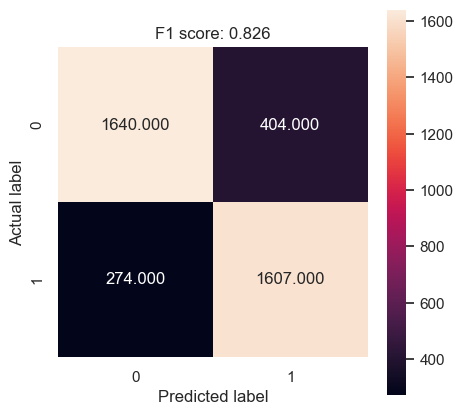

In [26]:
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".3f", square=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f"F1 score: {f1:.3f}")

Looks like model performed quite well – there is not much confusion between classes and f1 score looks good!